### ---------------------------------------------------------------------------------------------------------------------------------------------------------

# Fast Gradient-Descent Methods for Temporal-Difference Learning with Linear Function Approximation

### ---------------------------------------------------------------------------------------------------------------------------------------------------------

#### Richard S. Sutton, Hamid Reza Maei, Doina Precup, Shalabh Bhatnagar, David Silver, Csaba Szepesvari, EricWiewiora

https://webdocs.cs.ualberta.ca/~sutton/papers/SMPBSSW-09.pdf

### Introduction

Here, we consider the problem of estimating a value function $V_{\pi}$ using a linear approximation $V_{\theta} = \theta^T\Phi$ (where rows of $\Phi$ are the features describing each state).

As discussed in class, conventional Temporal Difference (TD) methods are not using *true* gradients, but *semi-*gradients. Indeed, in TD(0) with linear approximation the update rule is of the form:

$$\quad \theta_{k+1} \leftarrow \theta_k  + \alpha_k [R_k + \gamma V_{\theta}(s') - V_{\theta}(S)] \nabla V_{\theta}(S)$$

This expression is obtained by derivating the Mean Squarred Value Error (see below) wrt to $\theta$, and then, replacing the target $V_{\pi}$ by $R_k + \gamma V_{\theta}(s')$ (bootstrapping). Since $R_k + \gamma V_{\theta}(s')$ depends on $\theta$, this replacement is not fine theoretically: we do not use the exact gradients of $MSE(\theta)$, but *semi-gradients*.

$$ \quad  MSE(\theta) = \sum_{s \in \mathcal{S}} d(s) \left( V_{\pi}(s) - V_{\theta}(s) \right)^2 = \Vert V_{\pi} - V_{\theta} \Vert_D^2$$

While this approximation makes the training faster in practice (compared to MC-gradient methods for instance), using semi-gradients instead of true gradients makes the algorithm less robust, and not guaranteed to converge in the context of off-policy training. To tackle this issue, *Sutton, Szepesvari and Maei (2009)* (https://webdocs.cs.ualberta.ca/~sutton/papers/SSM-nips08.pdf) proposed a 'true' gradient, called **GTD**, algorithm which is guaranteed to converge, even in the context of off-policy training. Nevertheless, GTD is not as fast as TD, which has motivated the design of 2 fast gradient TD methods (**GTD2 and TDC**) which are described/implemented below.

### Notations

**Bellman Operator:** $\quad V = R + \gamma P V = TV$

**Temporal-difference error:**  $\quad \delta_k = r_k + \gamma \theta_k^T \Phi'_k - \theta_k^T\Phi_k$

The **Mean Squarred Bellman Error** measures how well $V_{\theta}$ satisfies the Bellman eaquation:$ \quad  MSBE(\theta) = \Vert V_{\theta} - T V_{\theta} \Vert_D^2 $

**Mean Square projected Bellman Error**: $ \quad  MSPBE(\theta) = \Vert V_{\theta} - \Pi T V_{\theta} \Vert_D^2 $

### Quick Summary

In order to use *true* gradients, GTD, GTD2 and TDC all optimizes another loss rather than $MSE(\theta)$.

As GTD2 and TDC are concerned, these algorithm are optimizing $MSPBE(\theta)$ which is defined as:

$$ \quad  MSPBE(\theta) = \Vert V_{\theta} - \Pi T V_{\theta} \Vert_D^2 $$

where $\Pi$ is a linear projector which projects any value function $v$ to the nearest value function representable by $V_\theta$. $\Pi$ has an analytical form: $\Pi = \Phi (\Phi^T D \Phi)^{-1} \Phi^TD$.

The paper shows that derivating this loss wrt to $\theta$ can lead to 2 update rules:

**GTD2 update rule** : $\theta_{k+1} \leftarrow \theta_k  + \alpha_k ( \Phi_k - \gamma \Phi'_k ) ( \Phi_k^T w_k )$ where $w_{k+1} = w_k + \beta_k (\delta_k - \Phi_k^T w_k)\Phi_k$

**TDC update rule**: $\theta_{k+1} \leftarrow \theta_k  + \alpha_k \delta_k \Phi_k - \alpha \gamma \Phi'_k(\Phi_k^Tw_k)$ (same $w_k$ as for GTD2) 

In comparison, **GTD** is optimizing another loss, called Norm of the expected TD error:

$$NEU(\theta) = \mathbb{E}[\delta \Phi]^T \mathbb{E}[\delta \Phi]$$

which leads to the following update rule:

**GTD update rule:** $\theta_{k+1} \leftarrow \theta_k  + \alpha_k ( \Phi_k - \gamma \Phi'_k ) ( \Phi_k^T u_k )$ where $u_{k+1} = u_k + \beta_k (\delta_k \Phi_k - u_k)$

Note that the TDC stands for **TD with Gradient Correction**. Indeed, the update rule involves 2 terms : the first one corresponds to the TD conventional update, while the second can be seen as a gradient correction to make the semi-gradient become an exact gradient. By initiating $w$ with $0s$ and keeping $\beta_k$ small, TDC will behave very similar to conventional TD.

** Advantages of the proposed "true" gradient algorithms: **

- Convergent with linear approximation under on-policy and off-policy learning.
- Time and Memory-complexity are O(n)
- Faster than the previous concurrent method GTD

### Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Random walk with state aggregation

![title](img/random_walk_with_state_aggregation.png)

For this task, $\Phi_s$ are are **one-hot vectors** and it is possible to simplify update rules by using $x^T \Phi_k = x_k$.

In [2]:
class RandomWalk():
    
    def __init__(self, length, aggregate_length, init, left_reward=-1, right_reward=+1):
        # Defining the environment
        self.length = length
        self.aggregate_length = aggregate_length
        self.states = np.arange(0, length+2)
        # and aggregates
        self.cuts = np.arange(1, length+1, aggregate_length)
        # Mapping state -> reward
        self.rewards = np.zeros(length+2)
        self.rewards[0] = left_reward
        self.rewards[-1] = right_reward
        # Mapping state -> aggregate
        self.aggregates = np.array([0] + [int((s-1)/aggregate_length)+1 for s in self.states[1:-1]] + [11]) 
        # Initial state
        self.init = init
        # Reset
        self.reset()
        
    def is_terminal(self):
        return self.current_state == 0 or self.current_state == self.length + 1
        
    def reset(self):
        self.current_state = self.init
        self.current_aggregate = self.aggregates[self.current_state]
        self.current_reward = self.rewards[self.current_state]
    
    def iterate(self, policy):
        # Sample from the policy
        next_state = policy(self.current_state)
        # Clip such that 0 < next_state < length
        self.current_state = np.clip(next_state, 0, self.length+1)
        self.current_aggregate = self.aggregates[self.current_state]
        self.current_reward = self.rewards[self.current_state]
        
    
    def visualize(self, margin=10):
        plt.figure(figsize=(16, 2))
        # Plot the environment
        plt.plot([1, self.length+2], [0, 0], linewidth=4)
        plt.plot([-margin, 1], [0, 0], linewidth=4, c="r")
        plt.plot([self.length+2, self.length+ 2 + margin], [0, 0], linewidth=4, c="g")
        # Vertical lines delimiting aggregates
        for cut in self.cuts:
            plt.plot([cut, cut], [-1, 1], linewidth=1, linestyle="--", c="k")
        plt.plot([self.length+1, self.length+1], [-1, 1], linewidth=1, linestyle="--", c="k") 
        # Plot the current state
        plt.scatter([self.current_state], [0], c="k", marker="s", s=50)
        plt.text(self.current_state-10, 0.2, self.current_state)
        # Xlim / Ylim
        plt.xticks(list(self.cuts) + [self.length+1])
        plt.ylim([-1, 1])
        plt.xlim([-margin, self.length+1 + margin])
        plt.show()

### Defining $\pi$

From one state, it is possible to go to the 10 next steps on the left, the 10 previous steps on the right, or stay in current position. 

In [3]:
def myCustomPolicy(state, delta_max=10):
    '''Warning: this function does not tackle edge problem: 
    states<0 and states>1000 are reachable.'''
    return np.random.randint(-delta_max, delta_max+1) + state

### Check the environment

Random walk = 10 aggregates of 10 steps

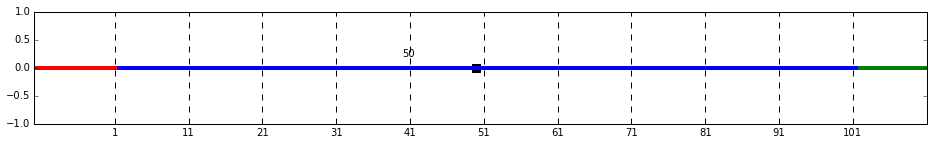

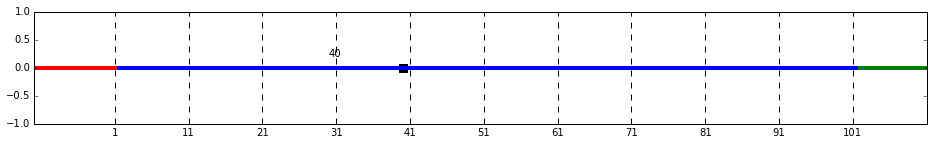

Reward: 0.0  - Terminal? False


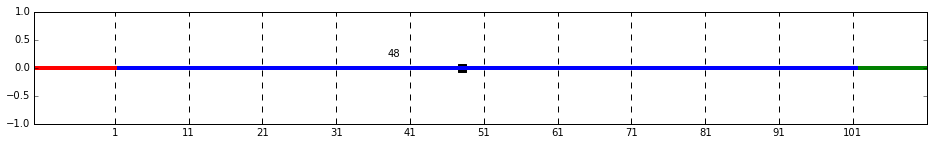

Reward: 0.0  - Terminal? False


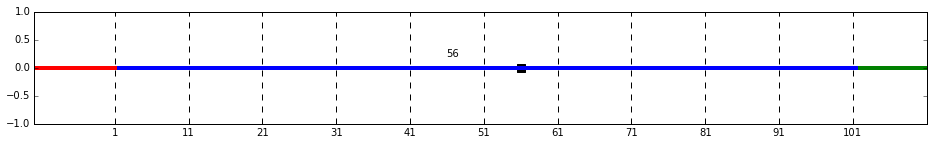

Reward: 0.0  - Terminal? False


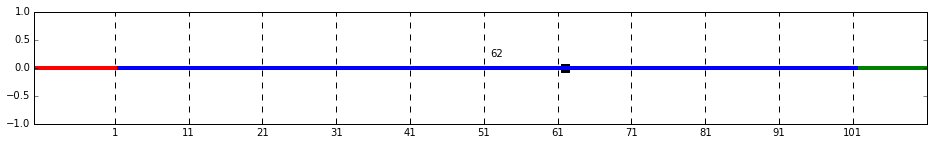

Reward: 0.0  - Terminal? False


In [4]:
random_walk = RandomWalk(100, 10, 50)
random_walk.visualize()
for i in range(4):
    random_walk.iterate(myCustomPolicy)
    random_walk.visualize()
    print "Reward:", random_walk.current_reward, " - Terminal?", random_walk.is_terminal()

### Policy Estimation base code

This code permits to evaluate V under a given policy using TD, GTD, GTD2 or TDC.

In [5]:
 def policyLearning(random_walk, policy, alpha, beta, gamma, theta_init, w_init, mode, 
                   nb_episodes=100000, verbose=True, max_iterations=10e6):
    assert mode in ["TD", "TDC", "GTD", "GTD2", "MC"]
    start = time.time()
    # Initialize with theta_init
    theta_hat = np.copy(theta_init)
    w = np.copy(w_init)
    # Loop over episodes
    theta_history = []
    TD_error_history = []
    w_history = []
    on_policy_distribution = np.zeros(random_walk.states.shape)
    for episode in range(nb_episodes):
        if verbose:
            print "\rEpisode %d..."%(episode),
        # Reset the environment (ie state=middle)
        random_walk.reset()
        on_policy_distribution[random_walk.current_state] += 1
        count = 0
        # Loop until it terminates
        while count < max_iterations:
            # Store S
            S = random_walk.current_aggregate
            # Observe R, S'
            random_walk.iterate(policy)
            on_policy_distribution[random_walk.current_state] += 1
            S_prime = random_walk.current_aggregate
            R = random_walk.current_reward
            # Update
            TD_error = (R + gamma*theta_hat[S_prime] - theta_hat[S])
            if mode == "TD":
                theta_hat[S] += alpha*TD_error
                
            elif mode == "GTD":
                theta_hat[S] += alpha*w[S]
                theta_hat[S_prime] -= alpha*gamma*w[S]
                w -= beta*w
                w[S] += beta*TD_error    
                
            elif mode == "GTD2":
                theta_hat[S] += alpha*w[S]
                theta_hat[S_prime] -= alpha*gamma*w[S]
                w[S] += beta*(TD_error - w[S])
            
            elif mode == "TDC":
                correction = w[S]
                theta_hat[S] += alpha*TD_error
                theta_hat[S_prime] -= alpha*gamma*correction
                w[S] += beta*(TD_error - w[S])
            
            # Check if the current state is terminal
            if random_walk.is_terminal():
                break
            count += 1
        # Save intermediate results
        theta_history.append(np.copy(theta_hat))
        TD_error_history.append(TD_error)
        w_history.append(w)
    end = time.time()
    # Scaling the on-policy distribution
    on_policy_distribution /= on_policy_distribution.sum()
    print("\rEvaluating V on %d episodes took %.1f s"%(nb_episodes, end-start))
    return theta_hat, theta_history, TD_error_history, w_history, on_policy_distribution

### Getting the true $V_{\pi}$

As the problem is not so big, it is possible to compute $V_{\pi}$ by inverting the Bellman equation: $$V_{\pi} = (I - \gamma P)^{-1}R $$

In [6]:
def get_transition_matrix(length, max_delta):
    # Init with zeros
    P = np.zeros((length+2, length+2))
    # Loop over rows
    for i in range(length):
        # Loop over cols
        for j in range(length):
            # Update probability of reachable states
            if abs(i-j) <= max_delta:
                P[i+1, j+1] = 1./(2*max_delta+1)
        # Update proba of terminal state s.t. each row sums to 1
        if i < length/2:
            P[i+1, 0] = 1. - P[i+1,:].sum()
        else:
            P[i+1, -1] = 1. - P[i+1,:].sum()
    return P

Invert the Bellman eq.:

In [7]:
gamma = 1.
P = get_transition_matrix(100, 10)
R = -1*P[:,0] + P[:,-1]
M = np.eye(102) - gamma*P
V = np.dot(np.linalg.inv(M), R)

Plot the true value $V_{\pi}$

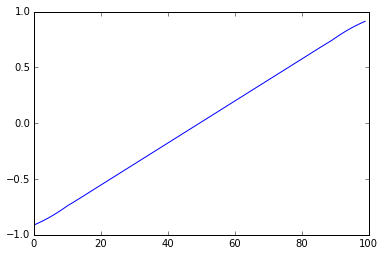

In [8]:
plt.plot(np.arange(100), V[1:-1])
plt.show()

### Input params

In [9]:
random_walk = RandomWalk(100, 10, 50)
alpha = 0.005
beta = alpha/2.
theta_init = np.zeros(random_walk.cuts.shape[0] + 2)
w_init = np.zeros(random_walk.cuts.shape[0] + 2)
nb_episodes = 50000

### Policy estimation varying the algorithm

In [11]:
np.random.seed(123)
results = dict()
for mode in ["TD", "GTD", "GTD2", "TDC"]:
    print "\n### Algorithm :", mode, "###"
    results[mode]  = policyLearning(random_walk, myCustomPolicy, alpha, beta, gamma, theta_init, w_init, mode,
                                    nb_episodes=nb_episodes)


### Algorithm : TD ###
Evaluating V on 50000 episodes took 41.6 s                                                                                                  

### Algorithm : GTD ###
Evaluating V on 50000 episodes took 67.0 s                                                                                                                                                              

### Algorithm : GTD2 ###
Evaluating V on 50000 episodes took 48.4 s                                                                                                                                  

### Algorithm : TDC ###
Evaluating V on 50000 episodes took 46.8 s                                                                                                               


### Plot $V_{\theta}$ for each algorithm

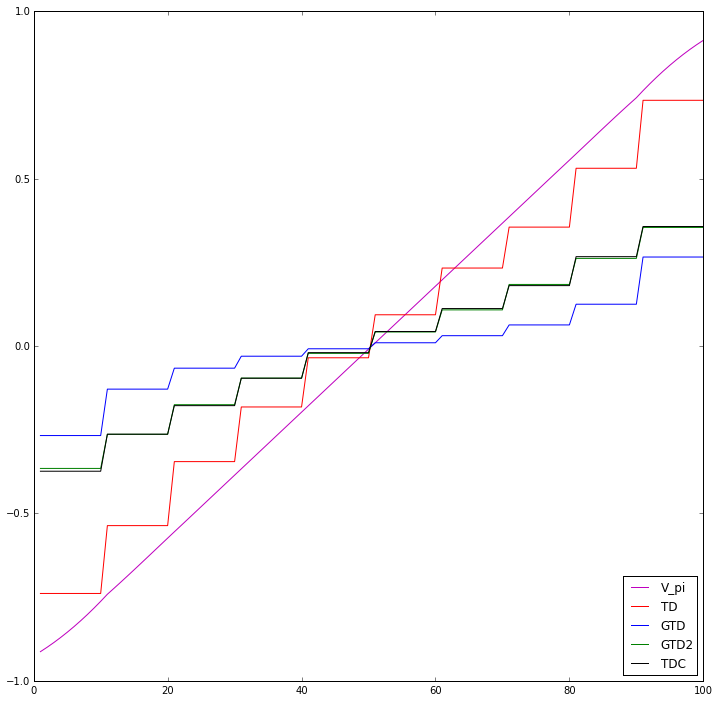

In [12]:
plt.figure(figsize=(12,12))
plt.plot(random_walk.states[1:-1], V[1:-1], label="V_pi", c="m")
for mode, c in zip(["TD", "GTD", "GTD2", "TDC"], ["r", "b", "g", "k"]):
    theta = results[mode][0]
    v_hat = [theta[s] for s in random_walk.aggregates]
    plt.plot(random_walk.states[1:-1], v_hat[1:-1], label=mode, c=c)
plt.legend(loc=4)
plt.show()

All TD solutions are **biased**. The conventional TD one is clearly the one which is the least biased: probably because it is the only which is optimizing $MSE(\theta)$.

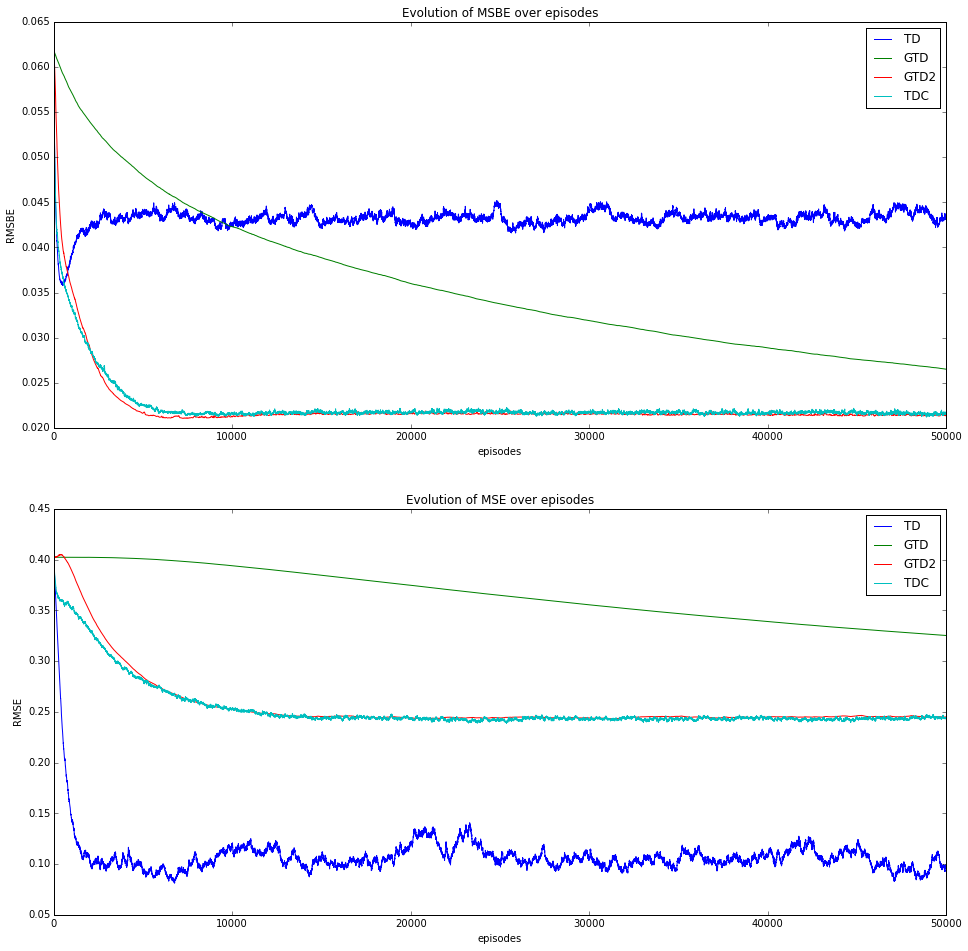

In [13]:
plt.figure(figsize=(16,16))
plt.subplot(2,1,1)
for mode in ["TD", "GTD", "GTD2", "TDC"]:
    theta_history = results[mode][1]
    d = results[mode][-1][1:-1]
    RMSBE = []
    for theta in theta_history:
        v_hat = [theta[s] for s in random_walk.aggregates]
        RMSBE.append(np.sqrt(np.sum(d*(((R+gamma*np.dot(P, v_hat)-v_hat)[1:-1])**2))))
    plt.plot(np.arange(0, nb_episodes), RMSBE, label=mode)
plt.legend()
plt.title("Evolution of MSBE over episodes")
plt.xlabel("episodes")
plt.ylabel("RMSBE")
plt.subplot(2,1,2)
for mode in ["TD", "GTD", "GTD2", "TDC"]:
    theta_history = results[mode][1]
    RMSE = []
    for theta in theta_history:
        v_hat = [theta[s] for s in random_walk.aggregates]
        RMSE.append(np.sqrt(np.sum(d*(((V-v_hat)[1:-1])**2))))
    plt.plot(np.arange(0, nb_episodes), RMSE, label=mode)
plt.legend()
plt.title("Evolution of MSE over episodes")
plt.ylabel("RMSE")
plt.xlabel("episodes")
plt.show()

These curves illustrate that **GTD2, TDC are much faster than GTD.**